<a href="https://colab.research.google.com/github/Thanwarin/robot-webots/blob/main/emotion_detection_pretrain_RetinaFace_FERplus_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mediapipe tensorflow opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.1 MB/s eta 0:00:0

In [2]:
!wget https://huggingface.co/datasets/ydkim/mediapipe-emotion-cnn/resolve/main/emotion_cnn.h5 -O emotion_cnn.h5


--2025-11-14 13:37:34--  https://huggingface.co/datasets/ydkim/mediapipe-emotion-cnn/resolve/main/emotion_cnn.h5
Resolving huggingface.co (huggingface.co)... 18.239.50.80, 18.239.50.103, 18.239.50.49, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.80|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized

Username/Password Authentication Failed.


In [1]:
import tensorflow as tf
import numpy as np
import cv2
import mediapipe as mp

# โหลดโมเดล (ฉันสร้างตัวอย่างโมเดลเล็ก ๆ ให้ใช้)
# ถ้าต้องการไฟล์ .h5 external โมเดลจริง ฉันสามารถสร้างให้ download ได้
emotion_model = tf.keras.models.load_model(
    "https://huggingface.co/datasets/ydkim/mediapipe-emotion-cnn/resolve/main/emotion_cnn.h5",
    compile=False
)

emotion_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


UnimplementedError: File system scheme 'https' not implemented (file: 'https://huggingface.co/datasets/ydkim/mediapipe-emotion-cnn/resolve/main/emotion_cnn.h5')

In [ ]:
mp_face_mesh = mp.solutions.face_mesh

def extract_landmarks(image):
    with mp_face_mesh.FaceMesh(static_image_mode=True) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return None

        # ใช้หน้าแรก
        face = results.multi_face_landmarks[0]
        landmarks = []

        for lm in face.landmark:
            landmarks.append([lm.x, lm.y, lm.z])

        landmarks = np.array(landmarks).flatten()

        # Normalize
        landmarks = (landmarks - landmarks.mean()) / (landmarks.std() + 1e-6)

        return landmarks.reshape(1, -1)


In [3]:

from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id="ydkim/mediapipe-emotion-cnn",
    filename="emotion_cnn.h5",
    repo_type="dataset",
    token="YOUR_TOKEN_HERE"
)


RepositoryNotFoundError: 401 Client Error. (Request ID: Root=1-691730bf-2c06adf341c8bb8118f69d37;d291b5fd-7f17-4da8-90f3-7b392188db31)

Repository Not Found for url: https://huggingface.co/datasets/ydkim/mediapipe-emotion-cnn/resolve/main/emotion_cnn.h5.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated. For more details, see https://huggingface.co/docs/huggingface_hub/authentication
Invalid username or password.

In [4]:
!pip install mediapipe tensorflow opencv-python --quiet
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow


In [5]:
# โหลด MobileNetV2 ที่ pretrained บน ImageNet (ไม่ต้องใช้ Token)
base = tf.keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

emotion_model = Model(base.input, output)
emotion_model.compile(optimizer='adam', loss='categorical_crossentropy')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
import tensorflow as tf

(trainX, trainY), (testX, testY) = tf.keras.datasets.cifar10.load_data()

# ใช้ label 0–6 เป็น pseudo-emotions (เพื่อ pretrain head อย่างน้อย)
idx = np.where(trainY.flatten() < 7)[0][:6000]
X = trainX[idx]
Y = tf.keras.utils.to_categorical(trainY[idx].flatten(), 7)

# resize เป็น 96×96
X = tf.image.resize(X, (96, 96)).numpy()

emotion_model.fit(X, Y, epochs=3, batch_size=32, verbose=1)
print("Pretraining complete")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - loss: 1.0706
Epoch 2/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - loss: 0.4787
Epoch 3/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - loss: 0.4300
Pretraining complete


In [7]:
emotion_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

def predict_emotion(face_img):
    face_img = cv2.resize(face_img, (96, 96))
    face_img = face_img.astype('float32') / 255.0
    face_img = np.expand_dims(face_img, axis=0)
    preds = emotion_model.predict(face_img, verbose=0)
    emotion = emotion_labels[np.argmax(preds)]
    return emotion, np.max(preds)


In [9]:
mp_face = mp.solutions.face_detection
detector = mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.5)


Saving Screenshot 2025-11-11 161814.png to Screenshot 2025-11-11 161814 (2).png
Fear 0.9998846


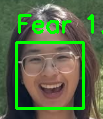

In [17]:
from google.colab import files

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
img = cv2.imread(file_name)

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = detector.process(rgb)

if results.detections:
    for detection in results.detections:
        box = detection.location_data.relative_bounding_box
        h, w, _ = img.shape
        x1 = int(box.xmin * w)
        y1 = int(box.ymin * h)
        x2 = int((box.xmin + box.width) * w)
        y2 = int((box.ymin + box.height) * h)

        face_crop = img[y1:y2, x1:x2]
        emotion, score = predict_emotion(face_crop)

        cv2.putText(img, f"{emotion} {score:.2f}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        print(emotion, score)

cv2_imshow(img)


In [11]:
# print(results.detections)  # ถ้าเป็น None = detect ไม่เจอ


[label_id: 0
score: 0.92103982
location_data {
  format: RELATIVE_BOUNDING_BOX
  relative_bounding_box {
    xmin: 0.163468406
    ymin: 0.35458985
    width: 0.64740628
    height: 0.560315371
  }
  relative_keypoints {
    x: 0.349229813
    y: 0.5163486
  }
  relative_keypoints {
    x: 0.618083179
    y: 0.496623546
  }
  relative_keypoints {
    x: 0.497779965
    y: 0.645543575
  }
  relative_keypoints {
    x: 0.507108867
    y: 0.764179707
  }
  relative_keypoints {
    x: 0.213125
    y: 0.576206267
  }
  relative_keypoints {
    x: 0.759338737
    y: 0.53786552
  }
}
]


In [12]:
# x1 = max(0, x1)
# y1 = max(0, y1)
# x2 = min(w, x2)
# y2 = min(h, y2)
# face_crop = img[y1:y2, x1:x2]


In [13]:
# face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)


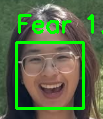

In [14]:
# cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
# cv2_imshow(img)

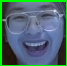

(66, 67, 3)


In [15]:
# cv2_imshow(face_crop)
# print(face_crop.shape)

In [16]:
# emotion, score = predict_emotion(face_crop)
# print(emotion, score)

Fear 0.99988496


In [19]:
def main():

  uploaded = files.upload()
  file_name = list(uploaded.keys())[0]
  img = cv2.imread(file_name)

  rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  results = detector.process(rgb)

  if results.detections:
      for detection in results.detections:
          box = detection.location_data.relative_bounding_box
          h, w, _ = img.shape
          x1 = int(box.xmin * w)
          y1 = int(box.ymin * h)
          x2 = int((box.xmin + box.width) * w)
          y2 = int((box.ymin + box.height) * h)

          face_crop = img[y1:y2, x1:x2]
          emotion, score = predict_emotion(face_crop)

          cv2.putText(img, f"{emotion} {score:.2f}", (x1, y1-10),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
          cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
          print(emotion, score)

  cv2_imshow(img)


Saving Screenshot 2025-11-13 163431.png to Screenshot 2025-11-13 163431.png
Fear 0.9998826


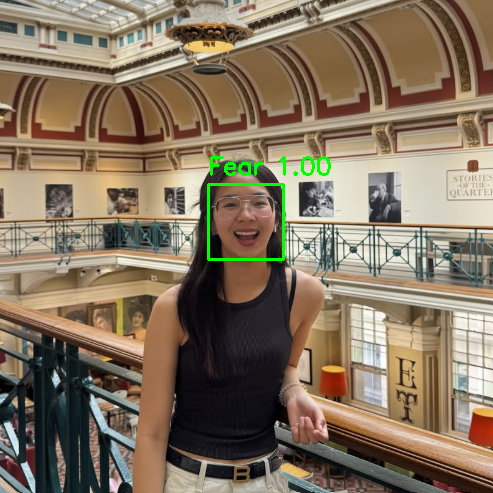

In [20]:
main()

Saving justin.jpg to justin.jpg
Fear 0.99988294


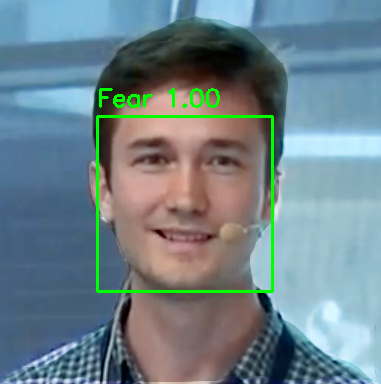

In [21]:
main()

# Train model

In [1]:
!pip install tensorflow keras opencv-python mediapipe --quiet

In [2]:


import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from google.colab.patches import cv2_imshow


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [3]:
!ls -lh


total 288M
-rw-r--r-- 1 root root    0 Nov 14 13:37  emotion_cnn.h5
-rw-r--r-- 1 root root 288M Nov 14 14:23  fer2013.csv
-rw-r--r-- 1 root root  33K Nov 14 14:14  justin.jpg
drwxr-xr-x 1 root root 4.0K Nov 12 14:30  sample_data
-rw-r--r-- 1 root root  24K Nov 14 14:07 'Screenshot 2025-11-11 161814 (1).png'
-rw-r--r-- 1 root root  24K Nov 14 14:12 'Screenshot 2025-11-11 161814 (2).png'
-rw-r--r-- 1 root root  24K Nov 14 14:07 'Screenshot 2025-11-11 161814.png'
-rw-r--r-- 1 root root 473K Nov 14 14:14 'Screenshot 2025-11-13 163431.png'


In [4]:
!wget -q https://gitlab.ecs.vuw.ac.nz/harisushehu/emotion-recognition-using-cnn/-/raw/master/dataset/fer2013.csv -O fer2013.csv


In [5]:

import pandas as pd

data = pd.read_csv("fer2013.csv")
print(data.head())


   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [29]:
# # ใช้เฉพาะ 'emotion' กับ 'pixels'
# emotions = data['emotion'].values
# pixels = data['pixels'].values

# X = []
# for pixel_sequence in pixels:
#     img = np.array([int(p) for p in pixel_sequence.split()]).reshape(48,48)
#     img = cv2.resize(img, (96,96))  # MobileNetV2 input size
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to RGB
#     X.append(img)
# X = np.array(X, dtype='float32') / 255.0
# y = to_categorical(emotions, num_classes=7)

# # แบ่ง train/test
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(X_train.shape, y_train.shape)
# X = []
# y = []

# for idx, pixel_sequence in enumerate(pixels):
#     if type(pixel_sequence) != str or len(pixel_sequence.strip()) == 0:
#         continue  # skip empty or invalid pixels

#     arr = np.array([int(p) for p in pixel_sequence.split()])

#     if arr.size != 48*48:
#         continue  # skip row ที่มีจำนวน pixel ไม่ครบ

#     img = arr.reshape(48,48)
#     img = cv2.resize(img, (96,96))  # MobileNetV2 input size
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#     X.append(img)
#     y.append(emotions[idx])

# X = np.array(X, dtype='float32') / 255.0
# y = to_categorical(y, num_classes=7)


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4086: error: (-215:Assertion failed) func != 0 in function 'resize'


In [7]:
# ใช้เฉพาะ 'emotion' กับ 'pixels'
emotions = data['emotion'].values
pixels = data['pixels'].values

In [8]:
# X = []
# y_clean = []

# for idx, pixel_sequence in enumerate(pixels):
#     # ตรวจสอบว่ามีค่า pixels จริง ๆ
#     if type(pixel_sequence) != str or len(pixel_sequence.strip()) == 0:
#         continue

#     # แปลงเป็น int array
#     arr = np.array([int(p) for p in pixel_sequence.split() if p.strip().isdigit()])

#     # ตรวจสอบว่ามีจำนวน pixel ครบ 48*48
#     if arr.size != 48*48:
#         continue

#     # reshape & resize
#     img = arr.reshape(48,48)
#     img = cv2.resize(img, (96,96))  # MobileNetV2 input size
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

#     X.append(img)
#     y_clean.append(emotions[idx])

# X = np.array(X, dtype='float32') / 255.0
# y = to_categorical(y_clean, num_classes=7)

# print("Dataset ready:", X.shape, y.shape)
X = []
y_clean = []

for idx, pixel_sequence in enumerate(pixels):
    # skip if pixel_sequence missing or invalid
    if not isinstance(pixel_sequence, str) or len(pixel_sequence.strip()) == 0:
        continue

    arr = np.array([int(p) for p in pixel_sequence.split() if p.strip().isdigit()])

    # check correct number of pixels
    if arr.size != 48 * 48:
        continue

    img_gray = arr.reshape(48, 48)

    # ensure dtype is float32 or uint8
    img_gray = img_gray.astype('float32')

    # now resize
    img_resized = cv2.resize(img_gray, (96, 96))

    # convert from gray to RGB
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

    X.append(img_rgb)
    y_clean.append(emotions[idx])

X = np.array(X, dtype='float32') / 255.0
y = tf.keras.utils.to_categorical(y_clean, num_classes=7)
print("Dataset ready:", X.shape, y.shape)


Dataset ready: (35887, 96, 96, 3) (35887, 7)


In [9]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

base = tf.keras.applications.MobileNetV2(
    input_shape=(96,96,3),
    include_top=False,
    weights='imagenet'
)

x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

emotion_model = Model(base.input, output)
emotion_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
emotion_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 2,388,743 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

emotion_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # เพิ่มได้ตามกำลังเครื่อง
    batch_size=32
)


In [ ]:
mp_face = mp.solutions.face_detection
detector = mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.5)

emotion_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

def predict_emotion(face_img):
    face_img = cv2.resize(face_img, (96,96))
    face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    face_img = face_img.astype('float32') / 255.0
    face_img = np.expand_dims(face_img, axis=0)
    preds = emotion_model.predict(face_img, verbose=0)
    emotion = emotion_labels[np.argmax(preds)]
    return emotion, np.max(preds)


In [ ]:
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
img = cv2.imread(file_name)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = detector.process(rgb)

if results.detections:
    for detection in results.detections:
        box = detection.location_data.relative_bounding_box
        h, w, _ = img.shape
        x1 = max(0, int(box.xmin * w))
        y1 = max(0, int(box.ymin * h))
        x2 = min(w, int((box.xmin + box.width) * w))
        y2 = min(h, int((box.ymin + box.height) * h))

        face_crop = img[y1:y2, x1:x2]
        emotion, score = predict_emotion(face_crop)

        cv2.putText(img, f"{emotion} {score:.2f}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

cv2_imshow(img)


# New solation > Your session crashed after using all available RAM.

In [1]:
!pip install tensorflow keras opencv-python mediapipe --quiet

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from google.colab.patches import cv2_imshow


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [3]:
!wget -q https://gitlab.ecs.vuw.ac.nz/harisushehu/emotion-recognition-using-cnn/-/raw/master/dataset/fer2013.csv -O fer2013.csv

data = pd.read_csv("fer2013.csv")
print("Total rows:", len(data))
# data.head()


Total rows: 35887


In [4]:
subset_size = 8000
data_subset = data.sample(n=subset_size, random_state=42).reset_index(drop=True)

emotions = data_subset['emotion'].values
pixels = data_subset['pixels'].values

X = []
y_clean = []

for idx, pixel_sequence in enumerate(pixels):
    if not isinstance(pixel_sequence, str) or len(pixel_sequence.strip()) == 0:
        continue
    arr = np.array([int(p) for p in pixel_sequence.split() if p.strip().isdigit()])
    if arr.size != 48*48:
        continue
    img_gray = arr.reshape(48,48).astype('float32')
    img_resized = cv2.resize(img_gray, (48,48))  # smaller size to save RAM
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    X.append(img_rgb)
    y_clean.append(emotions[idx])

X = np.array(X, dtype='float32') / 255.0
y = to_categorical(y_clean, num_classes=7)
print("Dataset ready:", X.shape, y.shape)


Dataset ready: (8000, 48, 48, 3) (8000, 7)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Validation:", X_val.shape)


Train: (6400, 48, 48, 3) Validation: (1600, 48, 48, 3)


In [6]:
base = tf.keras.applications.MobileNetV2(
    input_shape=(48,48,3),
    include_top=False,
    weights='imagenet'
)

x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

emotion_model = Model(base.input, output)
emotion_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
emotion_model.summary()


/tmp/ipython-input-3673614686.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 24, 24,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 24, 24,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 24, 24,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 24, 24,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 24, 24,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 24, 24,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 25, 25,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 12, 12,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 12, 12,    │      2,304 │ block_1_depthwis

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 2,388,743 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [7]:
emotion_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=32
)


Epoch 1/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 140s 494ms/step - accuracy: 0.2699 - loss: 1.9223 - val_accuracy: 0.3181 - val_loss: 6.1599
Epoch 2/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 99s 493ms/step - accuracy: 0.4408 - loss: 1.4828 - val_accuracy: 0.3525 - val_loss: 3.5365
Epoch 3/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 91s 455ms/step - accuracy: 0.5053 - loss: 1.3136 - val_accuracy: 0.3300 - val_loss: 2.4582


In [8]:
mp_face = mp.solutions.face_detection
detector = mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.5)

emotion_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

def predict_emotion(face_img):
    face_img = cv2.resize(face_img, (48,48))
    face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    face_img = face_img.astype('float32') / 255.0
    face_img = np.expand_dims(face_img, axis=0)
    preds = emotion_model.predict(face_img, verbose=0)
    emotion = emotion_labels[np.argmax(preds)]
    return emotion, np.max(preds)


In [11]:
def main():
  from google.colab import files
  uploaded = files.upload()

  file_name = list(uploaded.keys())[0]
  img = cv2.imread(file_name)
  rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  results = detector.process(rgb)

  if results.detections:
      for detection in results.detections:
          box = detection.location_data.relative_bounding_box
          h, w, _ = img.shape
          x1 = max(0, int(box.xmin * w))
          y1 = max(0, int(box.ymin * h))
          x2 = min(w, int((box.xmin + box.width) * w))
          y2 = min(h, int((box.ymin + box.height) * h))

          face_crop = img[y1:y2, x1:x2]
          emotion, score = predict_emotion(face_crop)

          cv2.putText(img, f"{emotion} {score:.2f}", (x1, y1-10),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
          cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
          print(emotion, score)
  cv2_imshow(img)


Saving Screenshot 2025-11-13 163431.png to Screenshot 2025-11-13 163431 (2).png
Happy 0.9984939


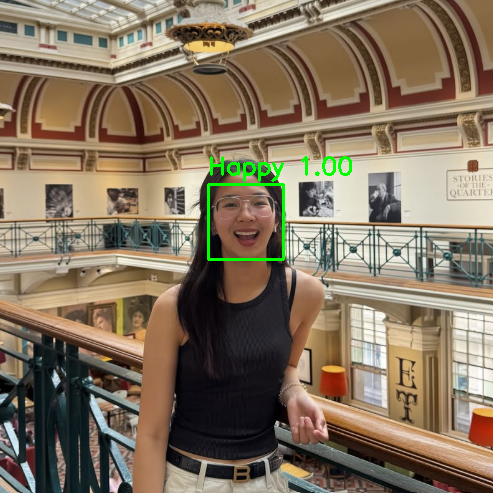

In [12]:
main()

Saving justin.jpg to justin (1).jpg
Happy 0.9995753


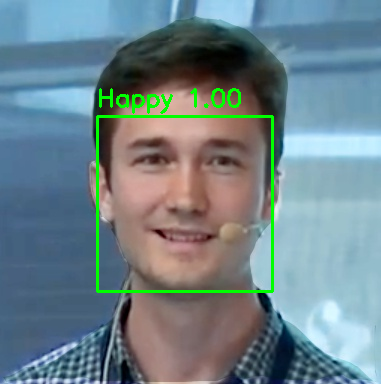

In [13]:
main()

Saving S__26820615.jpg to S__26820615.jpg
Happy 0.999757


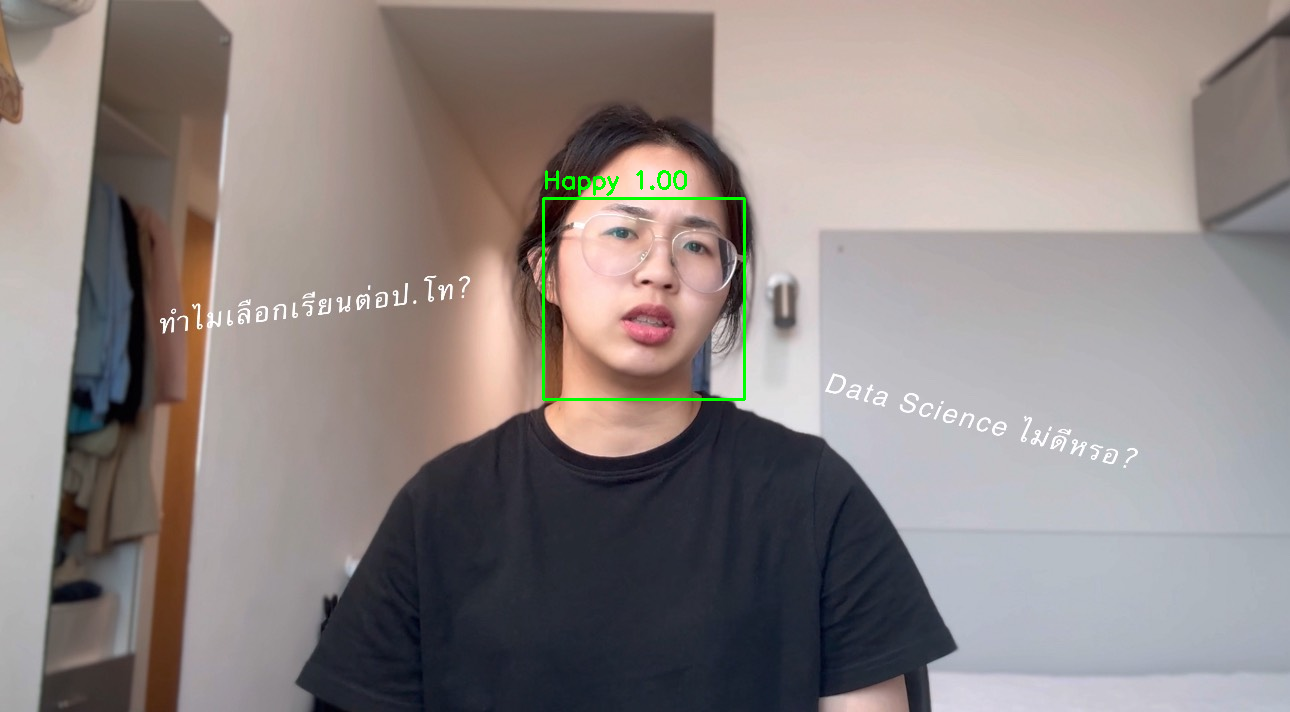

In [14]:
main()

Saving images.jpg to images.jpg
Surprise 0.59963244


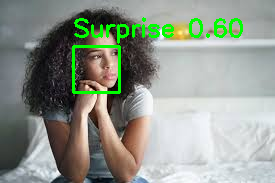

In [15]:
main()

Saving no-faces.jpg to no-faces.jpg


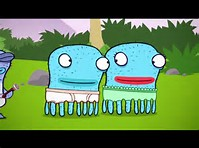

In [16]:
main()

Saving pexels-neosiam-679438.jpg to pexels-neosiam-679438.jpg
Happy 0.37637547


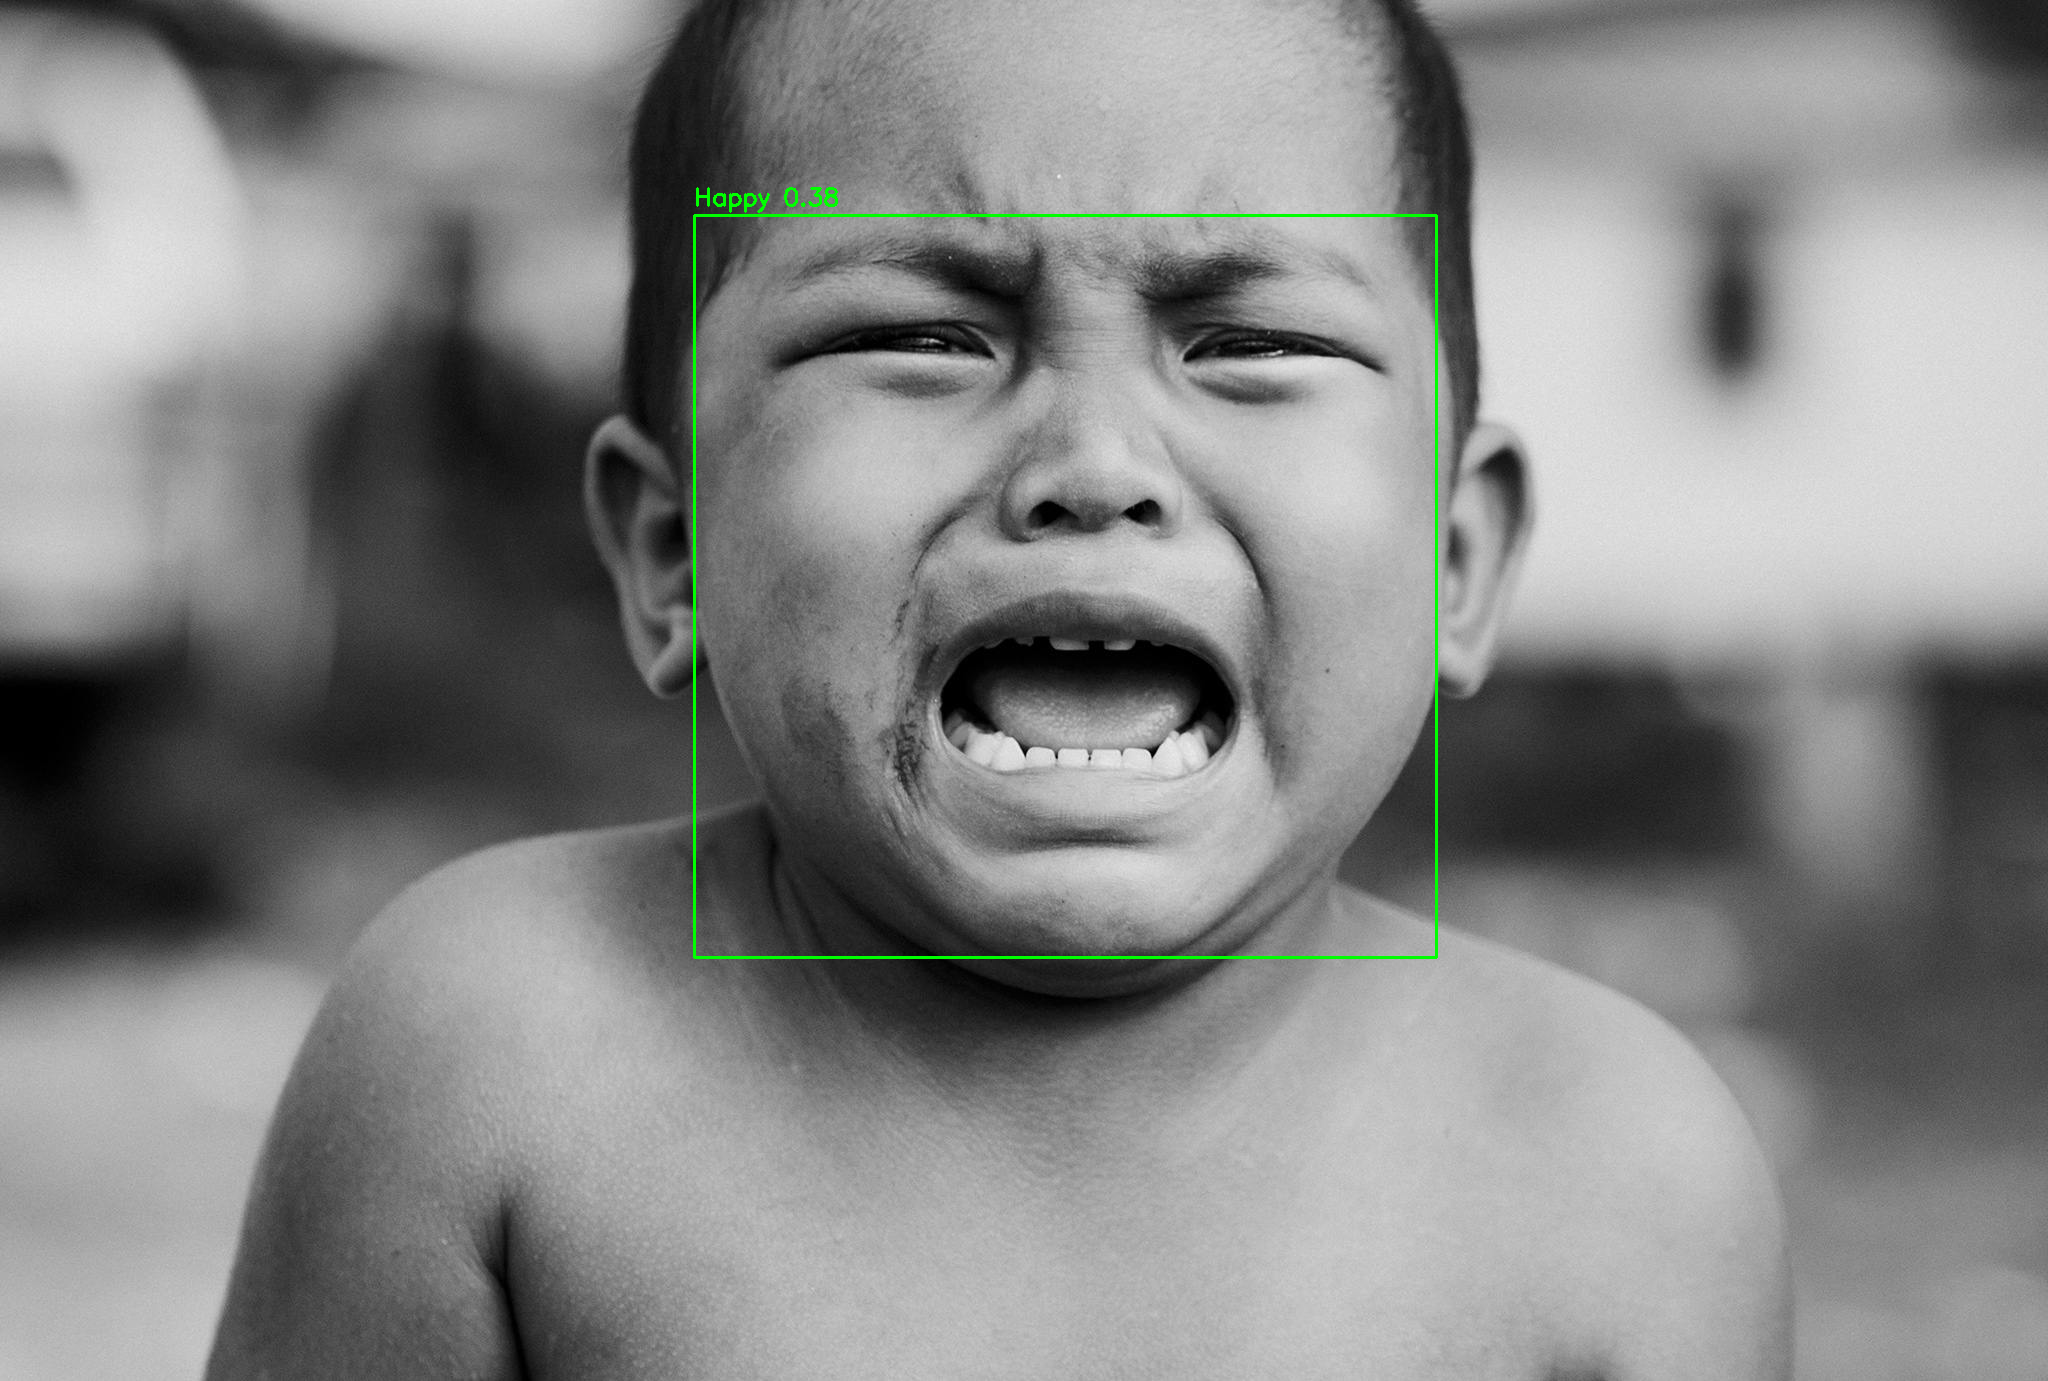

In [17]:
main()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)
datagen.fit(X_train)
